In [1]:
# Implement the Naïve Bayes algorithm from scratch to solve a real-world classification problem
# such as email spam detection, sentiment analysis, or disease diagnosis.

In [2]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt

In [3]:
# === Cell 2 — Load, clean, and split (short & error-free) ===
import numpy as np, pandas as pd, csv

# Load safely (works on any pandas version)
try:
    df = pd.read_csv("emails.csv")
except Exception:
    print("[Info] Standard read failed, using safe parser...")
    with open("emails.csv", "r", encoding="utf-8", errors="ignore") as f:
        rows = [r for r in csv.reader(f) if len(r) > 1]
    df = pd.DataFrame(rows[1:], columns=rows[0])

# Prepare features & labels
y = pd.to_numeric(df["Prediction"], errors="coerce").fillna(0).astype(int)
X = df.drop(columns=["Prediction", "Email No."], errors="ignore") \
       .apply(pd.to_numeric, errors="coerce").fillna(0)

# Stratified 75/25 split (no sklearn)
rng = np.random.default_rng(42)
idx0, idx1 = np.where(y==0)[0], np.where(y==1)[0]
rng.shuffle(idx0); rng.shuffle(idx1)
cut0, cut1 = int(0.75*len(idx0)), int(0.75*len(idx1))
train_idx = np.concatenate([idx0[:cut0], idx1[:cut1]])
test_idx  = np.concatenate([idx0[cut0:], idx1[cut1:]])
rng.shuffle(train_idx); rng.shuffle(test_idx)

X_train, y_train = X.iloc[train_idx].values, y.iloc[train_idx].values
X_test,  y_test  = X.iloc[test_idx].values,  y.iloc[test_idx].values

print("Data ready:", X_train.shape, X_test.shape)


Data ready: (3879, 3000) (1293, 3000)


Accuracy=0.9451  Precision=0.8838  Recall=0.9333  F1=0.9079


,Pred_Ham,Pred_Spam
True_Ham,872,46
True_Spam,25,350


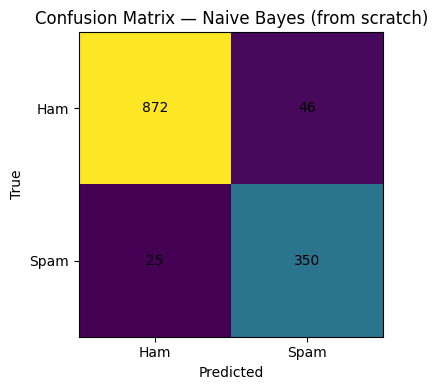

In [4]:
# === Cell 3 — Naive Bayes (from scratch), metrics, confusion matrix ===
import numpy as np, pandas as pd, matplotlib.pyplot as plt

# Multinomial NB with Laplace smoothing
alpha = 1.0
classes = np.array([0, 1])
V = X_train.shape[1]

# Counts per class
cls_counts = np.array([np.sum(y_train == c) for c in classes], dtype=float)
cls_log_prior = np.log(cls_counts / cls_counts.sum())
cls_feat_sum = np.vstack([X_train[y_train == c].sum(axis=0) for c in classes])  # (2, V)

# Likelihoods: P(w|c) = (count(w,c)+alpha) / (sum_w count(w,c) + alpha*V)
smoothed = cls_feat_sum + alpha
denom = cls_feat_sum.sum(axis=1, keepdims=True) + alpha * V
log_prob = np.log(smoothed / denom)  # shape (2, V)

# Predict on test set
log_joint = X_test @ log_prob.T + cls_log_prior     # (n, 2)
y_pred = classes[np.argmax(log_joint, axis=1)]

# Confusion matrix
cm = np.zeros((2, 2), dtype=int)
for t, p in zip(y_test, y_pred):
    cm[int(t), int(p)] += 1

# Metrics with zero-division safety
total = cm.sum()
acc = (cm[0,0] + cm[1,1]) / total if total else 0.0
prec_denom = (cm[0,1] + cm[1,1])
rec_denom  = (cm[1,0] + cm[1,1])
prec = cm[1,1] / prec_denom if prec_denom else 0.0
rec  = cm[1,1] / rec_denom  if rec_denom  else 0.0
f1   = (2*prec*rec)/(prec+rec) if (prec+rec) else 0.0

print(f"Accuracy={acc:.4f}  Precision={prec:.4f}  Recall={rec:.4f}  F1={f1:.4f}")
display(pd.DataFrame(cm, index=["True_Ham","True_Spam"], columns=["Pred_Ham","Pred_Spam"]))

# Plot confusion matrix
plt.figure(figsize=(5,4))
plt.imshow(cm, interpolation="nearest")
plt.title("Confusion Matrix — Naive Bayes (from scratch)")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.xticks([0,1], ["Ham","Spam"]); plt.yticks([0,1], ["Ham","Spam"])
for i in range(2):
    for j in range(2):
        plt.text(j, i, str(cm[i,j]), ha="center", va="center")
plt.tight_layout(); plt.show()
